In [2]:
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
#Load relevant data and create the full dataframe


filepath_met = "C:/Users/Stan/OneDrive - TU Eindhoven/Tue Dingen/DataChallenge2/DataParquet/Metropolitan-street.parquet"

# read the Parquet file into a pandas dataframe
df = pq.read_pandas(filepath_met).to_pandas()


barnet_df = df[df['LSOA name'].str.contains('Barnet')==True]
barnetBur_df = barnet_df[barnet_df['Crime type'].str.contains('Burglary')==True]
#barnetBur_df.head()

wards_csv = pd.read_csv("C:/Users/Stan/OneDrive - TU Eindhoven/Tue Dingen/DataChallenge2/DataParquet/LSOAtoWard.csv")
wards_relevant = wards_csv[['LSOA01NM', 'WD11NM']]
#wards_relevant

#Merge the main dataframe with the wards dataframe
merged_df = pd.merge(left=barnetBur_df, right=wards_relevant, left_on='LSOA name', right_on='LSOA01NM')

#Count the crimes comitted in a ward and the crimes in previous time windows in the same ward
df_crimes = merged_df[["Month", "Crime ID","WD11NM"]].copy()
df_crimes= df_crimes.groupby(["WD11NM","Month"]).count()

In [4]:

def rolling_sum2(group,y,str,s):
    group[str] = group['Crime ID'].rolling(window=y).sum().shift(s)
    return group

df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,1,"1Months",1))
df_crimes.fillna(0, inplace=True)
df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,2,"2Months",1))
df_crimes.fillna(0, inplace=True)
df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,3,"3Months",1))
df_crimes.fillna(0, inplace=True)
df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,4,"4Months",1))
df_crimes.fillna(0, inplace=True)
df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,12,"12Months",1))
df_crimes.fillna(0, inplace=True)

#df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,1,"1MonthsLag",2))
df_crimes.fillna(0, inplace=True)
df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,2,"2MonthsLag",3))
df_crimes.fillna(0, inplace=True)
#df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,3,"3MonthsLag",4))
df_crimes.fillna(0, inplace=True)
df_crimes = df_crimes.groupby('WD11NM', as_index=False).apply(lambda x: rolling_sum2(x,4,"4MonthsLag",5))
df_crimes.fillna(0, inplace=True)

#Merge the count of crimes to the main dataframe
merged_df = pd.merge(merged_df, df_crimes, on=['Month', 'WD11NM'], how='left')
merged_df.head()

,Crime ID_x,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,...,LSOA01NM,WD11NM,Crime ID_y,1Months,2Months,3Months,4Months,12Months,2MonthsLag,4MonthsLag
0,48d7fae1e76d275cfecabf17efbf6fecf769966089dcae...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.205163,51.655067,On or near Salisbury Road,E01000248,Barnet 001A,Burglary,...,Barnet 001A,High Barnet,7,3.0,15.0,24.0,36.0,161.0,21.0,59.0
1,d1d37e3e233d650abaf3eae1d6585e33f706cebe857ffc...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.203868,51.653824,On or near Union Street,E01000248,Barnet 001A,Burglary,...,Barnet 001A,High Barnet,7,3.0,15.0,24.0,36.0,161.0,21.0,59.0
2,6b13c905e40eccf73feec600e87a6c70e0667b10980e95...,2020-07,Metropolitan Police Service,Metropolitan Police Service,-0.207839,51.654289,On or near The Avenue,E01000248,Barnet 001A,Burglary,...,Barnet 001A,High Barnet,6,10.0,17.0,20.0,32.0,137.0,15.0,48.0
3,9869e99b7803ce398498332b862347626619671258ecdb...,2021-01,Metropolitan Police Service,Metropolitan Police Service,-0.205204,51.656578,On or near Strafford Road,E01000248,Barnet 001A,Burglary,...,Barnet 001A,High Barnet,10,4.0,16.0,26.0,44.0,118.0,28.0,38.0
4,83c73a8dfb5749e2f3922ff87ae87e3f0422e3cd8c88fa...,2021-01,Metropolitan Police Service,Metropolitan Police Service,-0.203575,51.655735,On or near Shopping Area,E01000248,Barnet 001A,Burglary,...,Barnet 001A,High Barnet,10,4.0,16.0,26.0,44.0,118.0,28.0,38.0


In [5]:
#Only 21 wards(should be 24) we have to check if this is different for data from a while ago
len(merged_df['WD11NM'].unique())

21

In [6]:
#Sklearn imports(and othrs)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [41]:

#Encode the wards
encoded_wards = pd.get_dummies(merged_df['WD11NM'])
df_months = pd.get_dummies(merged_df['Month'].str.split("-").str[-1].astype(int))
df_months.columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'okt', 'nov', 'dec']
#Creating the final dataframe with only relevant columns for the linear regression

df_final = encoded_wards
#Add months
df_final = df_final.join(df_months)
df_final['1Months'] = merged_df['1Months']
df_final['3Months'] = merged_df['3Months']
df_final['2Months'] = merged_df['2Months']
df_final['2MonthsLag'] = merged_df['2MonthsLag']
df_final['4Months'] = merged_df['4Months']
df_final['4MonthsLag'] = merged_df['4MonthsLag']
df_final['12Months'] = merged_df['12Months']
df_final['Crime ID_y'] = merged_df['Crime ID_y']



#Drop NaN otherwise linear regression doesnt work(Find out where the NaN is!!!)
df_final = df_final.dropna()

#Get the labels and features of the data
y = df_final['Crime ID_y']
X = df_final.drop(['Crime ID_y'], axis=1)

#scaler = StandardScaler()
#X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)



#X = merged_df[['2Months', '4Months', '6Months']]
#X = merged_df[['2Months' '2Months_lagg', '4Months', '4Months_lagg','6Months', 
#               '2Months_neighbor' '2Months_lagg_neighbor', '4Months_neighbor', 
#               '4Months_lagg_neighbor','6Months_neighbor']]

#Train/test split


#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
#                                               random_state=42, shuffle=True) 

In [40]:
df_months = pd.get_dummies(merged_df['Month'].str.split("-").str[-1].astype(int))
df_months.columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'okt', 'nov', 'dec']
df_months

,jan,feb,mar,apr,may,jun,jul,aug,sep,okt,nov,dec
0,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
43637,False,False,False,False,False,False,False,False,False,False,True,False
43638,False,False,False,False,False,False,False,False,False,False,False,True
43639,True,False,False,False,False,False,False,False,False,False,False,False
43640,True,False,False,False,False,False,False,False,False,False,False,False


In [42]:
#Linera regression for the crimes in a ward

reg = LinearRegression().fit(X, y)

predictions = reg.predict(X)


score = reg.score(X, y)
MAE = sum(abs(predictions - y))/len(predictions)
MSE = sum((predictions - y)**2)/len(predictions)

In [44]:
reg.coef_

array([ 3.81199434e+06,  3.81199443e+06,  3.81199624e+06,  3.81199377e+06,
        3.81199439e+06,  3.81199427e+06,  3.81199424e+06,  3.81199431e+06,
        3.81199479e+06,  3.81199538e+06,  3.81199479e+06,  3.81199455e+06,
        3.81199504e+06,  3.81199440e+06,  3.81199511e+06,  3.81199485e+06,
        3.81199402e+06,  3.81199432e+06,  3.81199458e+06,  3.81199486e+06,
        3.81199488e+06,  6.62985821e+09,  6.62985821e+09,  6.62985821e+09,
        6.62985821e+09,  6.62985821e+09,  6.62985821e+09,  6.62985821e+09,
        6.62985821e+09,  6.62985821e+09,  6.62985821e+09,  6.62985821e+09,
        6.62985821e+09,  2.70700201e-01,  8.47806715e-02, -1.48970168e+11,
       -1.48970168e+11,  1.48970168e+11,  6.95783601e-02, -1.88087192e-02])

Text(0.5, 1.0, 'Predicted mount of crimes per ward (R2=0.5272, MAE=4.5487, MSE=34.8544)')

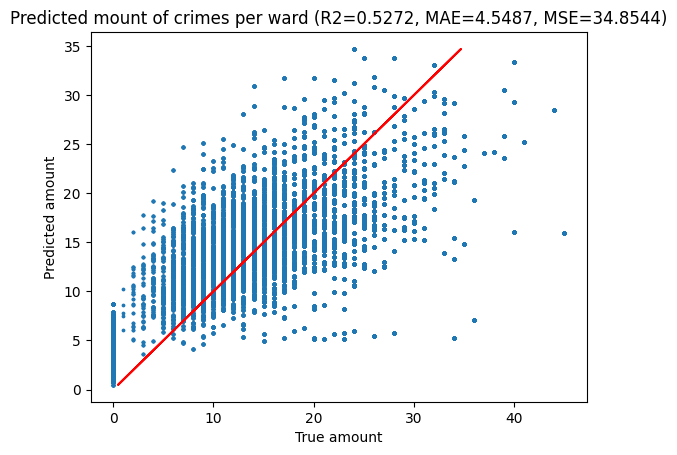

In [43]:
plt.scatter(y, predictions, s=3)

m, b = np.polyfit(predictions, y, 1)

plt.plot(predictions, m*predictions+b, c='r')

plt.xlabel('True amount')
plt.ylabel('Predicted amount')
plt.title(f'Predicted mount of crimes per ward (R2={score:.4f}, MAE={MAE:.4f}, MSE={MSE:.4f})')

Ideas:
-Binning for features
-Combining features
-clustering

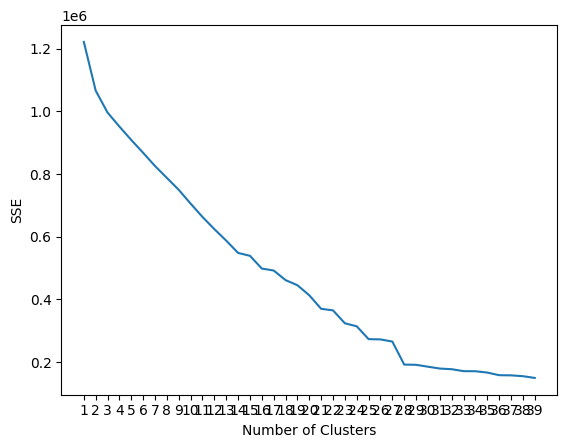

In [10]:
#Try to find clusters in the data
#The idea behind this is that there are hard to find patterns in the data and this way you can assign a burlary to similar ones

max_clusters = 40

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []


for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, max_clusters), sse)
plt.xticks(range(1, max_clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [20]:
#From the plot above we conclude that 30 clusters is the optimal amont of clusters

kmeans = KMeans(n_clusters=30, **kmeans_kwargs)
kmeans.fit(X_scaled)
results = kmeans.labels_


#Add clusters to the dataframe

merged_df['cluster'] = results


#Plot the clusters on the map
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

m_4 = folium.Map(location=[51.655067,-0.205163], tiles='cartodbpositron', zoom_start=13)
	

# Add a bubble map to the base map
for i in range(0,100):
    Circle(
        location=[merged_df.iloc[i]['Latitude'], merged_df.iloc[i]['Longitude']],
        radius=20,
        label=merged_df.iloc[i]['cluster']).add_to(m_4)

# Display the map
m_4

In [13]:
"""
#Random forest classifier(for predicting in which ward crimes will take place doesnt work anymore)

rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
 
#Obtain accuracy

print("Test Score:",rfc.score(X_test,y_test))

conf_mat = confusion_matrix(y_test, y_pred)
#print(conf_mat)

import seaborn
import matplotlib.pyplot as plt
seaborn.heatmap(conf_mat)
plt.show()
"""

'\n#Random forest classifier(for predicting in which ward crimes will take place doesnt work anymore)\n\nrfc = RandomForestClassifier(random_state = 42)\n\nrfc.fit(X_train,y_train)\ny_pred = rfc.predict(X_test)\n \n#Obtain accuracy\n\nprint("Test Score:",rfc.score(X_test,y_test))\n\nconf_mat = confusion_matrix(y_test, y_pred)\n#print(conf_mat)\n\nimport seaborn\nimport matplotlib.pyplot as plt\nseaborn.heatmap(conf_mat)\nplt.show()\n'